In [6]:
import ast
import pandas as pd
import re
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import math
from scipy.optimize import linear_sum_assignment


In [7]:
# Only use in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
def read_knot_data(filename):
    records = []

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # 1) Convert curly braces to square brackets
            line = line.replace('{', '[').replace('}', ']')

            # 2) Convert Mathematica *^ floats to Python e floats
            #    Do each sign separately, then default to no sign
            line = line.replace('*^-', 'e-')
            line = line.replace('*^+', 'e+')
            line = line.replace('*^', 'e')

            # 3) literal_eval
            data = ast.literal_eval(line)
            records.append(data)

    # Create DataFrame
    df = pd.DataFrame(records, columns=["knot_name", "J_zeros", "C_zeros", "volume"])
    return df

In [9]:
# If in Colab, read the knot data from Google Drive
# df_knots=read_knot_data("/content/drive/MyDrive/nameJ2zerosJ3zerosvol.txt")

# If not in Colab, read the knot data from local file
df_knots=read_knot_data("nameJ2zerosJ3zerosvol.txt")
df_knots.head()

,knot_name,J_zeros,C_zeros,volume
0,4_1,"[[-0.3090169943749479, -0.9510565162951543], [...","[[1.147115126315748, -0.4377033985664327], [1....",2.029883
1,5_2,"[[0.4556971463537512, -1.200152096461302], [0....","[[0.8022946724429645, -1.0189748088224135], [0...",2.828122
2,6_1,"[[0.07475104640853644, -1.2940511552254053], [...","[[0.23828627299108507, -1.2179129274123937], [...",3.163963
3,6_2,"[[0.28492014549902717, -1.1151405597204158], [...","[[-0.9169066951818676, -0.6468000055331047], [...",4.400833
4,6_3,"[[1.6355731299222214, 0], [0.27747906604368533...","[[1.435111800437746, -0.08824301780343402], [1...",5.693021


In [10]:
class KnotsDataset(Dataset):
    def __init__(self, df_knots, input_col='C_zeros', target_col='J_zeros'):
        """
        df_knots: a pandas DataFrame.
        input_col: name of the column containing the input list of [re, im] pairs.
        target_col: name of the column containing the target list of [re, im] pairs.
        """
        self.df_knots = df_knots.reset_index(drop=True)
        self.input_col = input_col
        self.target_col = target_col

    def __len__(self):
        return len(self.df_knots)

    def __getitem__(self, idx):
        """
        Return (x, y) where x is the list of [re, im] for J_roots_pos_imag,
        and y is the list of [re, im] for C_roots_pos_imag.
        """
        row = self.df_knots.iloc[idx]
        x = row[self.input_col]  # a list of [real, imag]
        y = row[self.target_col] # a list of [real, imag]
        return x, y

In [11]:
def knots_collate_fn(batch):
    """
    batch: list of (x, y), where:
      x is a list of [re, im] floats,
      y is a list of [re, im] floats.

    Returns:
      x_tensor: (batch_size, max_len, 2) float
      x_mask:   (batch_size, max_len) bool  (True=valid, False=pad)
      y_tensor: (batch_size, max_len, 3) float
                where [re, im, 0] = valid
                      [0,  0,  1] = padded
    """
    # Separate out all x and y
    x_list = [item[0] for item in batch]  # list of lists of [re, im]
    y_list = [item[1] for item in batch]

    batch_size = len(batch)
    # Find the maximum lengths
    max_len_x = max((len(x_seq) for x_seq in x_list), default=0)
    max_len_y = max((len(y_seq) for y_seq in y_list), default=0)
    max_len   = max(max_len_x, max_len_y)  # unify so we can compare 1:1

    # Create tensors
    x_tensor = torch.zeros((batch_size, max_len, 2), dtype=torch.float)
    x_mask   = torch.zeros((batch_size, max_len), dtype=torch.bool)

    # For y, we have an extra dimension for the "valid/pad" flag
    y_tensor = torch.zeros((batch_size, max_len, 3), dtype=torch.float)

    # Fill each row
    for i, (x_seq, y_seq) in enumerate(zip(x_list, y_list)):
        # --- Inputs ---
        Lx = len(x_seq)
        for j in range(Lx):
            re_val, im_val = x_seq[j]
            x_tensor[i, j, 0] = re_val
            x_tensor[i, j, 1] = im_val
            x_mask[i, j] = True  # Mark valid

        # --- Targets ---
        Ly = len(y_seq)
        for j in range(Ly):
            re_val, im_val = y_seq[j]
            y_tensor[i, j, 0] = re_val
            y_tensor[i, j, 1] = im_val
            y_tensor[i, j, 2] = 1.0  # 1 => valid token (matches confidence)

        for j in range(Ly, max_len):
            y_tensor[i, j, 2] = 0.0  # 0 => padded

    return x_tensor, x_mask, y_tensor

In [12]:
batch_size = 32
num_workers = 2

train_df, valtest_df = train_test_split(df_knots, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(valtest_df, test_size=0.5, random_state=42)

train_dataset = KnotsDataset(train_df, input_col='C_zeros', target_col='J_zeros')
val_dataset = KnotsDataset(val_df, input_col='C_zeros', target_col='J_zeros')
test_dataset = KnotsDataset(test_df, input_col='C_zeros', target_col='J_zeros')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=knots_collate_fn)#, multiprocessing_context="forkserver", persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=knots_collate_fn)#, multiprocessing_context="forkserver", persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=knots_collate_fn)#, multiprocessing_context="forkserver", persistent_workers=True)

In [13]:
num_knots = len(train_loader.dataset)
print("Number of knots:", num_knots)

for x_tensor, x_mask, y_tensor in train_loader:
    print("x_tensor shape:", x_tensor.shape)  # (batch_size, max_len, 2)
    print("y_tensor shape:", y_tensor.shape)  # (batch_size, max_len, 3)
    break

Number of knots: 141836
x_tensor shape: torch.Size([32, 63, 2])
y_tensor shape: torch.Size([32, 63, 3])


In [14]:
class ChamferLoss(nn.Module):
    def __init__(self, lambda_coord=1.0, lambda_conf=1.0, lambda_reg=.1, alpha=10.0):
        super().__init__()
        self.lambda_coord = lambda_coord
        self.lambda_conf = lambda_conf
        self.lambda_reg = lambda_reg
        self.alpha = alpha

    def forward(self, pred_tensor, y_tensor):
        pred_coords = pred_tensor[..., :2]                  # (B, M, 2)
        pred_scores = torch.sigmoid(pred_tensor[..., 2:])   # (B, M, 1) ← FIXED

        true_coords = y_tensor[..., :2]
        true_scores = y_tensor[..., 2:]

        chamfer = self._chamfer_loss(pred_coords, true_coords, true_scores)
        conf_targets = self._confidence_targets(pred_coords, true_coords, true_scores)
        conf_loss = F.binary_cross_entropy(pred_scores, conf_targets)

        return self.lambda_coord * chamfer + self.lambda_conf * conf_loss + self.lambda_reg * (pred_scores ** 2).mean()

    def _chamfer_loss(self, pred_coords, true_coords, true_scores):
        """
        Weighted chamfer loss ignoring padded targets.
        """
        B, M, _ = pred_coords.shape
        N = true_coords.shape[1]
        loss = 0.0

        for b in range(B):
            tgt_mask = true_scores[b].squeeze(-1) > 0  # (N,)
            tgt_valid = true_coords[b][tgt_mask]       # (N_valid, 2)
            prd = pred_coords[b]                       # (M, 2)

            if tgt_valid.shape[0] == 0:
                continue

            dists = torch.cdist(prd, tgt_valid)  # (M, N_valid)
            min_pred_to_tgt = dists.min(dim=1)[0].mean()
            min_tgt_to_pred = dists.min(dim=0)[0].mean()
            loss += min_pred_to_tgt + min_tgt_to_pred

        return loss / B

    def _confidence_targets(self, pred_coords, true_coords, true_scores): # This seems sus, fix it
        """
        Compute soft targets for predicted confidences using
        soft-min similarity with ground truth coordinates.
        """
        B, M, _ = pred_coords.shape
        N = true_coords.shape[1]

        dists = torch.cdist(pred_coords, true_coords)  # (B, M, N)

        pad_mask = (true_scores.squeeze(-1) == 0).unsqueeze(1)  # (B, 1, N)
        dists = dists.masked_fill(pad_mask, float('inf'))

        soft_scores = torch.exp(-self.alpha * dists ** 2)  # (B, M, N)
        targets = soft_scores.max(dim=2, keepdim=True)[0]  # (B, M, 1)
        return targets


In [15]:
"""Very slow, not differentiable"""

class HungarianLoss(nn.Module):
    def __init__(self, lambda_coord=1.0, lambda_conf=1.0, lambda_fp=1.0, threshold=0.01):
        """
        lambda_coord: weight for coordinate loss
        lambda_conf: weight for matched confidence loss
        lambda_fp: weight for unmatched prediction (false positive) penalty
        threshold: confidence threshold for considering a predicted point valid
        """
        super().__init__()
        self.lambda_coord = lambda_coord
        self.lambda_conf = lambda_conf
        self.lambda_fp = lambda_fp
        self.threshold = threshold

    def forward(self, pred_tensor, target_tensor):
        """
        pred_tensor:  (B, M, 3) – predicted (x, y, conf), conf ∈ [0, 1] (already sigmoid-ed)
        target_tensor: (B, M, 3) – target (x, y, conf), where conf = 0 indicates padding
        """
        device = pred_tensor.device
        batch_size, _, _ = pred_tensor.shape
        total_loss = 0.0
        valid_batches = 0

        for b in range(batch_size):
            pred = pred_tensor[b]      # (M, 3)
            target = target_tensor[b]  # (M, 3)

            # Filter predicted points with low confidence
            pred_valid_mask = pred[:, 2] > self.threshold
            pred_valid = pred[pred_valid_mask]

            # Filter target (non-padding) points
            target_valid_mask = target[:, 2] > 0.5
            target_valid = target[target_valid_mask]

            if pred_valid.shape[0] == 0 and target_valid.shape[0] == 0:
                continue  # skip completely empty samples

            if pred_valid.shape[0] == 0 or target_valid.shape[0] == 0:
                # If only one side is empty, treat all preds as false positives or all targets as missed
                unmatched_preds = pred[pred_valid_mask]
                if unmatched_preds.shape[0] > 0:
                    fp_loss = F.binary_cross_entropy(
                        unmatched_preds[:, 2].clamp(0.0, 1.0),
                        torch.zeros_like(unmatched_preds[:, 2])
                    )
                    total_loss += self.lambda_fp * fp_loss
                    valid_batches += 1
                continue

            # Compute cost matrix (squared L2 distance)
            cost = torch.cdist(pred_valid[:, :2], target_valid[:, :2], p=2).pow(2)
            row_ind, col_ind = linear_sum_assignment(cost.detach().cpu().numpy())

            matched_preds = pred_valid[row_ind]         # (K, 3)
            matched_targets = target_valid[col_ind]     # (K, 3)

            # Coordinate loss
            coord_loss = F.mse_loss(matched_preds[:, :2], matched_targets[:, :2])

            # Confidence loss for matched points
            matched_pred_conf = matched_preds[:, 2].clamp(0.0, 1.0)
            matched_target_conf = matched_targets[:, 2]
            conf_loss = F.binary_cross_entropy(matched_pred_conf, matched_target_conf)

            # Confidence loss for unmatched predictions (false positives)
            all_indices = torch.arange(pred_valid.shape[0], device=device)
            unmatched_mask = ~torch.isin(all_indices, torch.tensor(row_ind, device=device))
            if unmatched_mask.any():
                unmatched_preds = pred_valid[unmatched_mask]
                fp_conf_loss = F.binary_cross_entropy(
                    unmatched_preds[:, 2].clamp(0.0, 1.0),
                    torch.zeros_like(unmatched_preds[:, 2])
                )
            else:
                fp_conf_loss = torch.tensor(0.0, device=device)

            total_loss += (
                self.lambda_coord * coord_loss +
                self.lambda_conf * conf_loss +
                self.lambda_fp * fp_conf_loss
            )
            valid_batches += 1

        if valid_batches == 0:
            return torch.tensor(0.0, device=pred_tensor.device, requires_grad=True)
        return total_loss / valid_batches

In [16]:
def sinkhorn(log_alpha, mask_pred, mask_target, n_iters=20, eps=1e-6):
    """
    log_alpha: (B, M, N)
    mask_pred: (B, M)
    mask_target: (B, N)
    Returns soft assignment (B, M, N) respecting masks
    """
    B, M, N = log_alpha.shape

    # Masked log_alpha: set invalid entries to -inf (for logsumexp)
    mask = mask_pred.unsqueeze(2) * mask_target.unsqueeze(1)  # (B, M, N)
    log_alpha = log_alpha.masked_fill(mask == 0, float('-inf'))

    # Stabilize
    log_alpha = log_alpha - torch.nan_to_num(torch.amax(log_alpha, dim=[1, 2], keepdim=True), nan=0.0)

    for _ in range(n_iters):
        log_alpha = log_alpha - torch.logsumexp(log_alpha, dim=2, keepdim=True)
        log_alpha = log_alpha - torch.logsumexp(log_alpha, dim=1, keepdim=True)

    return log_alpha.exp() * mask  # ensure zeros outside valid area


class SinkHornLoss(nn.Module):
    def __init__(self, lambda_coord=1.0, lambda_conf=1.0, lambda_fp=1.0):
        super().__init__()
        self.lambda_coord = lambda_coord
        self.lambda_conf = lambda_conf
        self.lambda_fp = lambda_fp

    def forward(self, pred_tensor, target_tensor):
        """
        pred_tensor: (B, M, 3) – (x, y, conf)
        target_tensor: (B, N, 3) – (x, y, conf), conf=0 means padding
        """
        B, M, _ = pred_tensor.shape
        N = target_tensor.shape[1]

        pred_xy = pred_tensor[:, :, :2]
        pred_conf = pred_tensor[:, :, 2]

        target_xy = target_tensor[:, :, :2]
        target_conf = target_tensor[:, :, 2]

        # Masks: 1 for valid entries, 0 for padded
        mask_pred = (pred_conf > 0.01).float()
        mask_target = (target_conf > 0.01).float()

        # Pairwise squared distances
        diff = pred_xy.unsqueeze(2) - target_xy.unsqueeze(1)
        dist_sq = (diff ** 2).sum(dim=-1)  # (B, M, N)

        log_alpha = -dist_sq

        # Sinkhorn soft match with masks
        P = sinkhorn(log_alpha, mask_pred, mask_target)  # (B, M, N)

        # Coord loss: weighted squared distance
        coord_loss = (P * dist_sq).sum(dim=[1, 2])  # (B,)

        # Confidence target: weighted sum of matched target confs
        conf_target = (P * target_conf.unsqueeze(1)).sum(dim=2)  # (B, M)
        conf_loss = F.binary_cross_entropy(pred_conf.clamp(0, 1), conf_target, reduction='none')
        conf_loss = (conf_loss * mask_pred).sum(dim=1)

        # Overprediction penalty: unmatched predictions → conf ≈ 0
        matched_mass = P.sum(dim=2)  # (B, M)
        fp_loss = (F.binary_cross_entropy(pred_conf.clamp(0, 1), torch.zeros_like(pred_conf), reduction='none') *
                   (1.0 - matched_mass) * mask_pred).sum(dim=1)

        total_loss = (
            self.lambda_coord * coord_loss +
            self.lambda_conf * conf_loss +
            self.lambda_fp * fp_loss
        )

        return total_loss.mean()

In [17]:
class DeepSets(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=128, num_outputs=49):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.pooling = lambda x, mask: torch.sum(x * mask.unsqueeze(-1), dim=1)  # (B, hidden_dim)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_outputs * 3)  # (x, y, confidence)
        )
        self.num_outputs = num_outputs

    def forward(self, x, mask):
        encoded = self.encoder(x)                        # (B, L, hidden_dim)
        pooled = self.pooling(encoded, mask)             # (B, hidden_dim)
        decoded = self.decoder(pooled)                   # (B, num_outputs * 3)
        decoded = decoded.view(-1, self.num_outputs, 3)  # (B, M, 3)
        decoded[..., 2] = decoded[..., 2].sigmoid() 
        return decoded

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [24]:
"""
TODO:
 - Increase size
 - Try Hungarian loss/play with loss params
 - Confidence regularization
 - Punish more for coord outliers
"""
model = DeepSets(hidden_dim=512).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = HungarianLoss(3, 1, 4, .1).to(device)
num_epochs = 15

for epoch in range(num_epochs):
    model.train() # Training loop
    train_loss = 0.0
    for x_tensor, x_mask, y_tensor in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
        x_tensor = x_tensor.to(device)
        x_mask   = x_mask.to(device)
        y_tensor = y_tensor.to(device)

        pred_tensor = model(x_tensor, x_mask)
        loss = loss_fn(pred_tensor, y_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    model.eval() # Val loop
    val_loss = 0.0
    with torch.no_grad():
        for x_tensor, x_mask, y_tensor in val_loader:
            x_tensor = x_tensor.to(device)
            x_mask   = x_mask.to(device)
            y_tensor = y_tensor.to(device)

            pred_tensor = model(x_tensor, x_mask)
            loss = loss_fn(pred_tensor, y_tensor)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")


Epoch 1/15 - Train:   0%|          | 0/4433 [00:00<?, ?it/s]

Epoch 1/15 - Train: 100%|██████████| 4433/4433 [04:26<00:00, 16.61it/s] 


Epoch 1 - Train Loss: 1.7461 - Val Loss: 1.1048


Epoch 2/15 - Train:  79%|███████▊  | 3486/4433 [10:15<02:47,  5.66it/s]  


KeyboardInterrupt: 

In [25]:
torch.save(model.state_dict(), "deepsets_model.pt")

In [26]:
# Load model
model = DeepSets(in_dim=2, hidden_dim=512, num_outputs=49).to(device)
model.load_state_dict(torch.load("deepsets_model.pt", map_location=device))
model.eval()


DeepSets(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=147, bias=True)
  )
)

In [27]:
def plot_batch_pred_vs_actual(pred_tensor, y_tensor, n=4, show_confidence=True):
    """
    Plot side-by-side subplots of predicted vs actual points.

    Parameters:
    - pred_tensor: (B, M, 3) — predicted [x, y, confidence]
    - y_tensor: (B, M, 3) — ground truth [x, y, confidence]
    - n: int — number of batch elements to plot
    - show_confidence: bool — whether to use confidence as alpha for predicted
    """
    pred_tensor = pred_tensor.detach().cpu()
    y_tensor = y_tensor.detach().cpu()

    batch_size = pred_tensor.shape[0]
    n = min(n, batch_size)

    cols = min(n, 4)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten()

    for i in range(n):
        pred_coords = pred_tensor[i, :, :2].numpy()
        pred_conf = pred_tensor[i, :, 2].numpy()

        true_coords = y_tensor[i, :, :2].numpy()
        true_conf = y_tensor[i, :, 2].numpy()
        true_coords = true_coords[true_conf > 0]

        ax = axes[i]
        ax.scatter(true_coords[:, 0], true_coords[:, 1], c='blue', label='Actual', alpha=0.6)
        if show_confidence:
            ax.scatter(pred_coords[:, 0], pred_coords[:, 1], c='red', alpha=pred_conf.clip(0.05, 1.0), label='Predicted')
        else:
            ax.scatter(pred_coords[:, 0], pred_coords[:, 1], c='red', label='Predicted')

        ax.set_title(f'Example {i}')
        ax.axis('equal')
        ax.grid(True)

    # Turn off unused axes
    for j in range(n, len(axes)):
        axes[j].axis('off')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()


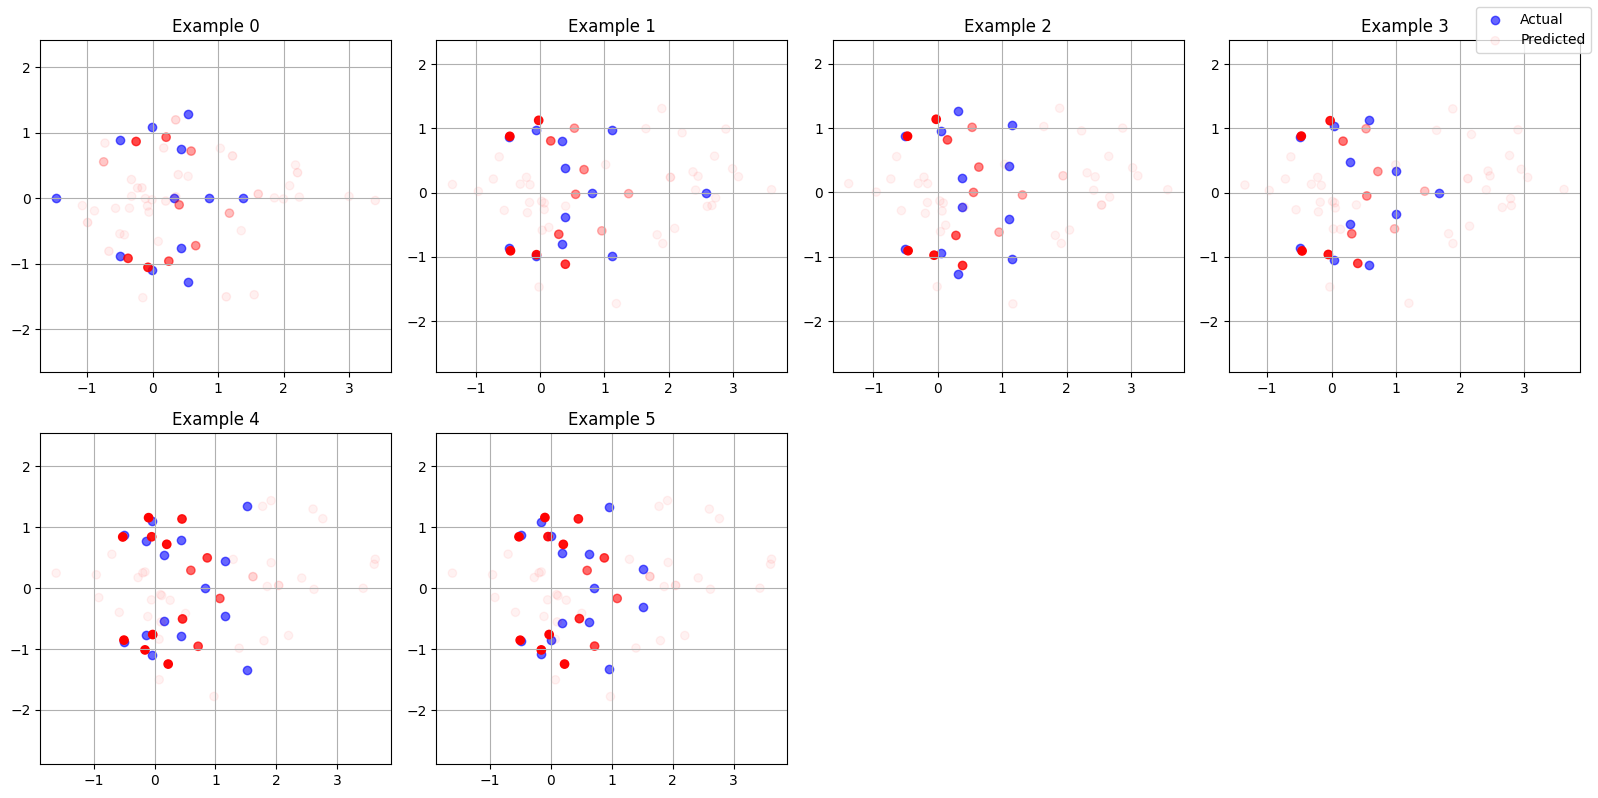

In [28]:
with torch.no_grad():
    model.eval()
    for x_tensor, x_mask, y_tensor in test_loader:
        x_tensor = x_tensor.to(device)
        x_mask = x_mask.to(device)
        y_tensor = y_tensor.to(device)

        pred_tensor = model(x_tensor, x_mask)
        plot_batch_pred_vs_actual(pred_tensor, y_tensor, n=6)
        break
